# Week 6: Transfer learning and multitask learning

Deep neural networks can be **extremely expensive** to train. Training a good classifier on a complex task, like telling objects in images apart, or determining whether a move in a board game is good, can take weeks on multiple GPUs, cost millions of dollars in cloud computing fees and release massive amounts of CO$_2$ into the atmosphere ([some models more than 5 cars over their entire lifetimes](https://arxiv.org/pdf/1906.02243.pdf)). Because of this, we want to be able to **reuse** weights in models we have trained. This is called transfer learning. The fundamental idea is that things learned in one context can be *transferred* to another context.



## Exercises

We will follow a well-written [blog post](https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/) by Jason Brownlee of 'Machine Learning 
Mastery' for most of these exercises. In his blog post, Jason takes the reader through
the process of using pretrained models in Keras. Below, the steps you
will go through are outlined with reference to his blog post. It is strongly recommend you read from the
top and down to 'Models for Transfer Learning' before proceeding.

### Loading pretrained models

The first practical thing we need to figure out when doing transfer learning is loading pretrained models. Keras makes this very easy by offering a number of pretrained models for image classification which can be downloaded through their [Applications API](https://keras.io/applications/#densenet). 

#### Applications API arguments

When loading pretrained models, we will want to provide some arguments that depend on what
we want to do with the model after loading. Below I ask you to explain, in your own words,
what some of these parameters do. See the Application API reference on some of the models
and the 'Models for Transfer Learning' section in Jason's blog post for help.

> **Ex. 6.1.1**: In your own words, explain what the following function arguments do in
the different model loading functions:
1. `include_top`
1. `weights`
1. `input_shape`
1. `pooling`
1. `classes`

1. include_top is used to specify whether you want to use the pretrained model as is or whether to use as a feature extractor like we talked about in class, where you use the model's weights and structures and replace the last ouput layer with a new classifier layer. when include_top is set to False, the model is loaded except for the fully connected output layer.
2. Weights specifies whether the model should be loaded with the trained weights (eg used as is as a pre-trained model) or should be loaded with random weights. Loading with random weights randomizes all weights but keeps the structure of the model the same so that you could train that previously successful structure on your own and end up with your own custom trained weights.
3. input_shape is used to specify the dimensions of the inputs you are putting into the model if they are different than what the model was already trained on. Chaning the input_shape allows you to apply the existing pre-trained model to a new input size say a different sized image than the ones the model was trained on.
4. pooling allows you to specify a pooling layer which as we have learned, classifies the output of a convolutional or other layer into a single vector representation that can easily be used to downsize the activations. in this case the pooling options are maxpooling or average pooling and are used when you set your own output layer with include_top. Using pooling gets you the output vector that describes the classification of the input image.
5. classes is similar to input_shape but for the output of the model, telling the pretrained model how many output classification types you will have. By setting classes, the model will automatically configure your ouput layer to a vector of that size. 

#### Load a model and predict an image

> **Ex. 6.1.2**: Following Jason's example under 'Pre-Trained Model as Classifier'
classify [this image](https://images.squarespace-cdn.com/content/v1/58f0ecc029687fbef7b86b03/1583064484458-IM0UKAZIONS6E2CFCDJC/ke17ZwdGBToddI8pDm48kD5ENJpXCfmjfXuRxqpPb-1Zw-zPPgdn4jUwVcJE1ZvWQUxwkmyExglNqGp0IvTJZUJFbgE-7XRK3dMEBRBhUpyN2spBBImrH38afc2UL8XBF0s2RHqmX-QW0wG37RpCsIsNysB0CO3b7e86dkNKVNs/Otter+Makes+an+Immediate+U-Turn+Back+to+the+Water.jpg?format=1500w).
Print not just the most likely label, but everything that `decode_predictions` returns. Depending on your tensorflow version you would have use `tensorflow.keras.utils` in stead of `tensorflow.keras.preprocessing.image`
>
> ***Important***: *The VGG16 model he uses is 500 MB to download, and will take quite long to load and apply.
> Rather use one of the smaller models instead ([here](https://keras.io/applications/#documentation-for-individual-models)'s an overview of model sizes), such as DenseNet121.*

In [40]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.densenet import preprocess_input
from keras.applications.densenet import decode_predictions
from keras.applications.densenet import DenseNet121
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression



# load an image from file
image = load_img('Otter+Makes+an+Immediate+U-Turn+Back+to+the+Water.jpg', target_size=(224, 224))
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)

# load the model
model = DenseNet121()
# predict the probability across all output classes
yhat = model.predict(image)
# convert the probabilities to class labels
label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
label1 = label[0][0]
# print the classification
print('%s (%.2f%%)' % (label1[1], label1[2]*100))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
otter (33.49%)


In [41]:
label2 = label[0]
print(label2)
print('\n')
for item in label2:
    print("Label: %s, %f" % (item[1], item[2]*100))

[('n02444819', 'otter', 0.33485153), ('n02363005', 'beaver', 0.31281742), ('n02442845', 'mink', 0.09657538), ('n02396427', 'wild_boar', 0.05625628), ('n02395406', 'hog', 0.03840031)]


Label: otter, 33.485153
Label: beaver, 31.281742
Label: mink, 9.657538
Label: wild_boar, 5.625628
Label: hog, 3.840031


### Adapting pretrained models

#### Feature extractor for ML prediction

By removing the last layer, we can turn a pretrained convolutional neural network into a
*feature extractor*. We can then use it to extract features of a large number of images and
classify those using any machine learning model. Jason describes this under 'Pre-Trained Model as Feature Extractor Preprocessor'.

> **Ex. 6.2.1:** Say you've have been out all day taking pictures of cats and dogs (or maybe it's just a subset from [kaggle.com/c/dogs-vs-cats](https://www.kaggle.com/c/dogs-vs-cats)) but you haven't managed to take very many pictures and label them because it's hard work. This makes it hard to train a model of the size needed in order to tell the difference between dogs and cats. Download the data from canvas (Module 6, *ex6_cats_and_dogs.zip*) and 
> - Visualize some random images
> - Then train a logistic regression classifier on the **raw data**, i.e. every pixel value is a feature, and report the accuracy on the test data
>
>Below is some code that loads and splits the data into training and test data, then flattens the images into the data-matrix format.
>
> *Hint: You can import logistic regression from sklearn. It has a simple API where you basically only need the `.fit` and `.predict` methods of the logistic regression object. You can check out one of the examples on the [documentation page](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).*

In [42]:
import numpy as np
import matplotlib.pyplot as plt

In [43]:
X = np.load('X_cat_vs_dog.npz')['arr_0']
Y = np.load('Y_cat_vs_dog.npz')['arr_0']

# Split train/test
x_train = X[0:500]
y_train = Y[0:500]
x_test = X[500:]
y_test = Y[500:] 

# Flattens the images into the data-matrix format that most sklearn models accept
x_raw_train = x_train.flatten().reshape([x_train.shape[0], 200*200*3])
x_raw_test = x_test.flatten().reshape([x_test.shape[0], 200*200*3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


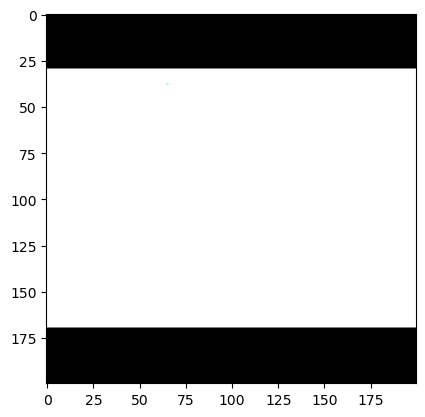

In [44]:
# Visualize first image
plt.imshow(X[0])

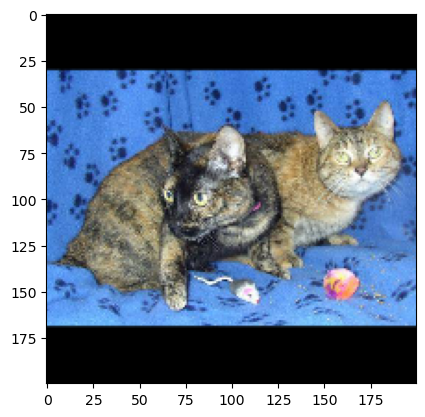

In [45]:
# Normalize, then visualize first image
plt.imshow(X[0]/255)

This is a cat


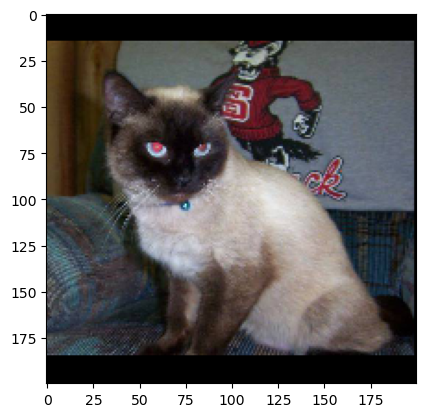

In [46]:
# Display random cat/dog
random_image = np.random.randint(len(Y))
plt.imshow(X[random_image,:,:,:]/255)
print('This is a %s' %( {0:'dog', 1:'cat'}[Y[random_image]] ) )

Four random images visualized with labels


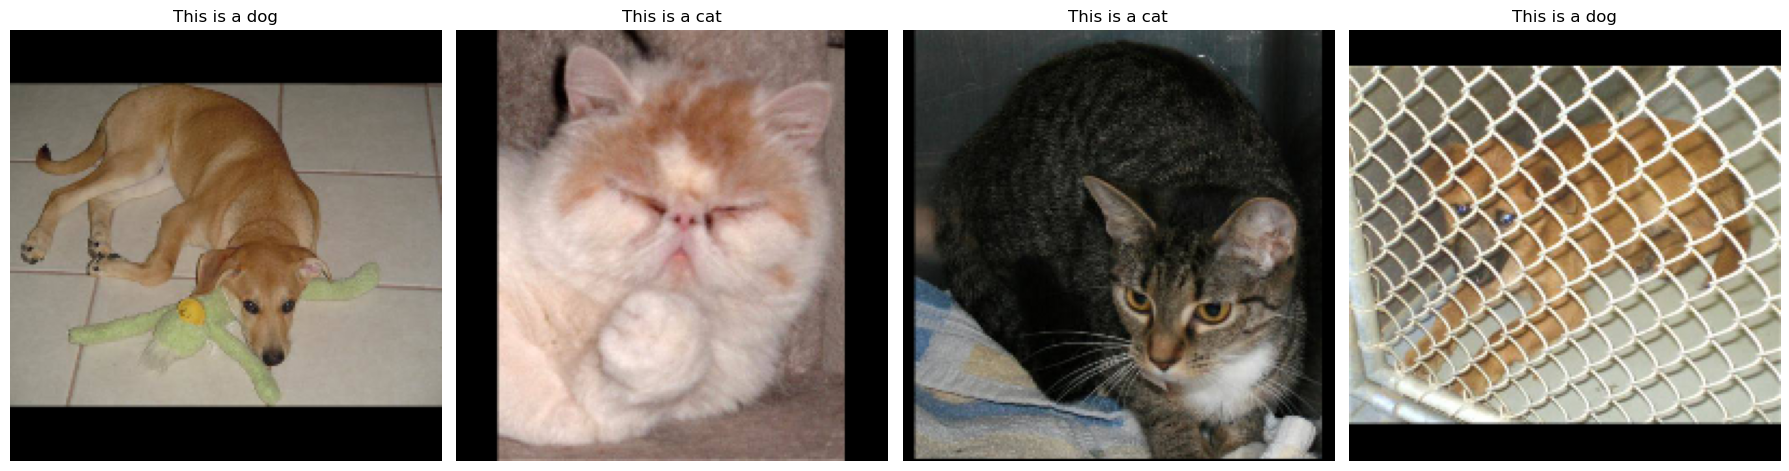

In [47]:
random_images = np.random.randint(len(Y), size=4)
fig, axes = plt.subplots(1, 4, figsize=(18, 18))

for i, ax in enumerate(axes.flat):
    idx = random_images[i]
    ax.imshow(X[idx,:,:,:]/255) #display normalized
    ax.set_title('This is a %s' % ({0:'dog', 1:'cat'}[Y[idx]])) # set title as label
    ax.axis('off')
print("Four random images visualized with labels")
plt.tight_layout()
plt.show()

In [48]:
# Create a logistic regression model
non_feature_model = LogisticRegression(max_iter=1000)

# Train the model
non_feature_model.fit(x_raw_train, y_train)

# evaluate
accuracy = non_feature_model.score(x_raw_test, y_test)
print(f'Model accuracy: {accuracy:.2f}')

Model accuracy: 0.55


The model's accuracy is only 55% which is barely better than randomly selecting or chosing 'dog' as every guess. This is because a logistic regression is not a very strong method for image classification.

> **Ex. 6.2.2:** Now, extract features for each datapoint, using a pre-trained neural network, thus building train and test input matrices `x_train_FE` and `x_test_FE`. Train a logistic regression classifier on the learned features, and report the accuracy on the test data.
You should be getting a significantly better performance than when using the raw data.
>
> Explain why that is; what work did the pretrained network do for you to be able to use the most simple classifier and get such great performance on a clearly nonlinear problem?

In [49]:
print(X[0].shape)
print(image.shape)

(200, 200, 3)
(1, 224, 224, 3)


In [50]:
# Depending on whether the people who first developed the neural network normalized the data while training
# you might need to normalize as well

x_train /= 255
x_test /= 255


from keras.models import Model
from keras.layers import Input

new_input = Input(shape=(200, 200, 3)) # create input shape for existing model
featue_extractor_model = DenseNet121(include_top = False, input_tensor = new_input) #remove last layer with include_top and set the input size with input_tensor

# extract features
x_train_FE = featue_extractor_model.predict(x_train)
x_test_FE = featue_extractor_model.predict(x_test)



16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 618ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 537ms/step


In [51]:
print(x_train_FE.shape)
print(x_test_FE.shape)

(500, 6, 6, 1024)
(500, 6, 6, 1024)


In [52]:
# flatten to use with logistic regression model
x_raw_train_FE = x_train_FE.flatten().reshape([x_train_FE.shape[0], 6 * 6 * 1024])
x_raw_test_FE = x_test_FE.flatten().reshape([x_test_FE.shape[0], 6 * 6 * 1024])

print(x_raw_train_FE.shape) #confirm sizes are correct
print(x_raw_test_FE.shape)   


(500, 36864)
(500, 36864)


In [53]:
# Create a logistic regression model
feature_classifier_model = LogisticRegression(max_iter=10000)  # Increase max_iter if needed for convergence

# Train the model
feature_classifier_model.fit(x_raw_train_FE, y_train)

# Optionally, you can evaluate the model on the test set
accuracy = feature_classifier_model.score(x_raw_test_FE, y_test)
print(f'Model accuracy: {accuracy:.2f}')

Model accuracy: 0.95


A basic logistic regression model is a linear model which by nature cannot understand the patterns of images and their spacial connection. Cat and dog images are complex and varied and there is no way to easily draw a simple linear model which would understand these differences and be able to classify the images. However, with the pretrained model as a feature extractor, we use the power of the existing DenseNet121 which is trained to understand the high level complex features of an image that contain more important and understandable information for the following logistic regression like edges, texture, shapes, etc. This turns the problem into one that a linear model can more easily understand because if it sees a certain combination of features it can predict a certain classification with more certainty than just seeing a set of pixels. Additionally, the feature extractor reduces the dimensionality of the problem by a significant amount, making it much simpler for the logistic regression model. In the image below we show the output of the feature extractor and how the logistic regression model would have a much easier time interpreting and classifying that output. Thus we see a large improvement in accuracy from 55% to 95% which is significantly better than nearly random guessing as the simple logistic regression without feature extractor did. We see that performing a logistic regression on the learned image features is a fairly good way to classify these images!

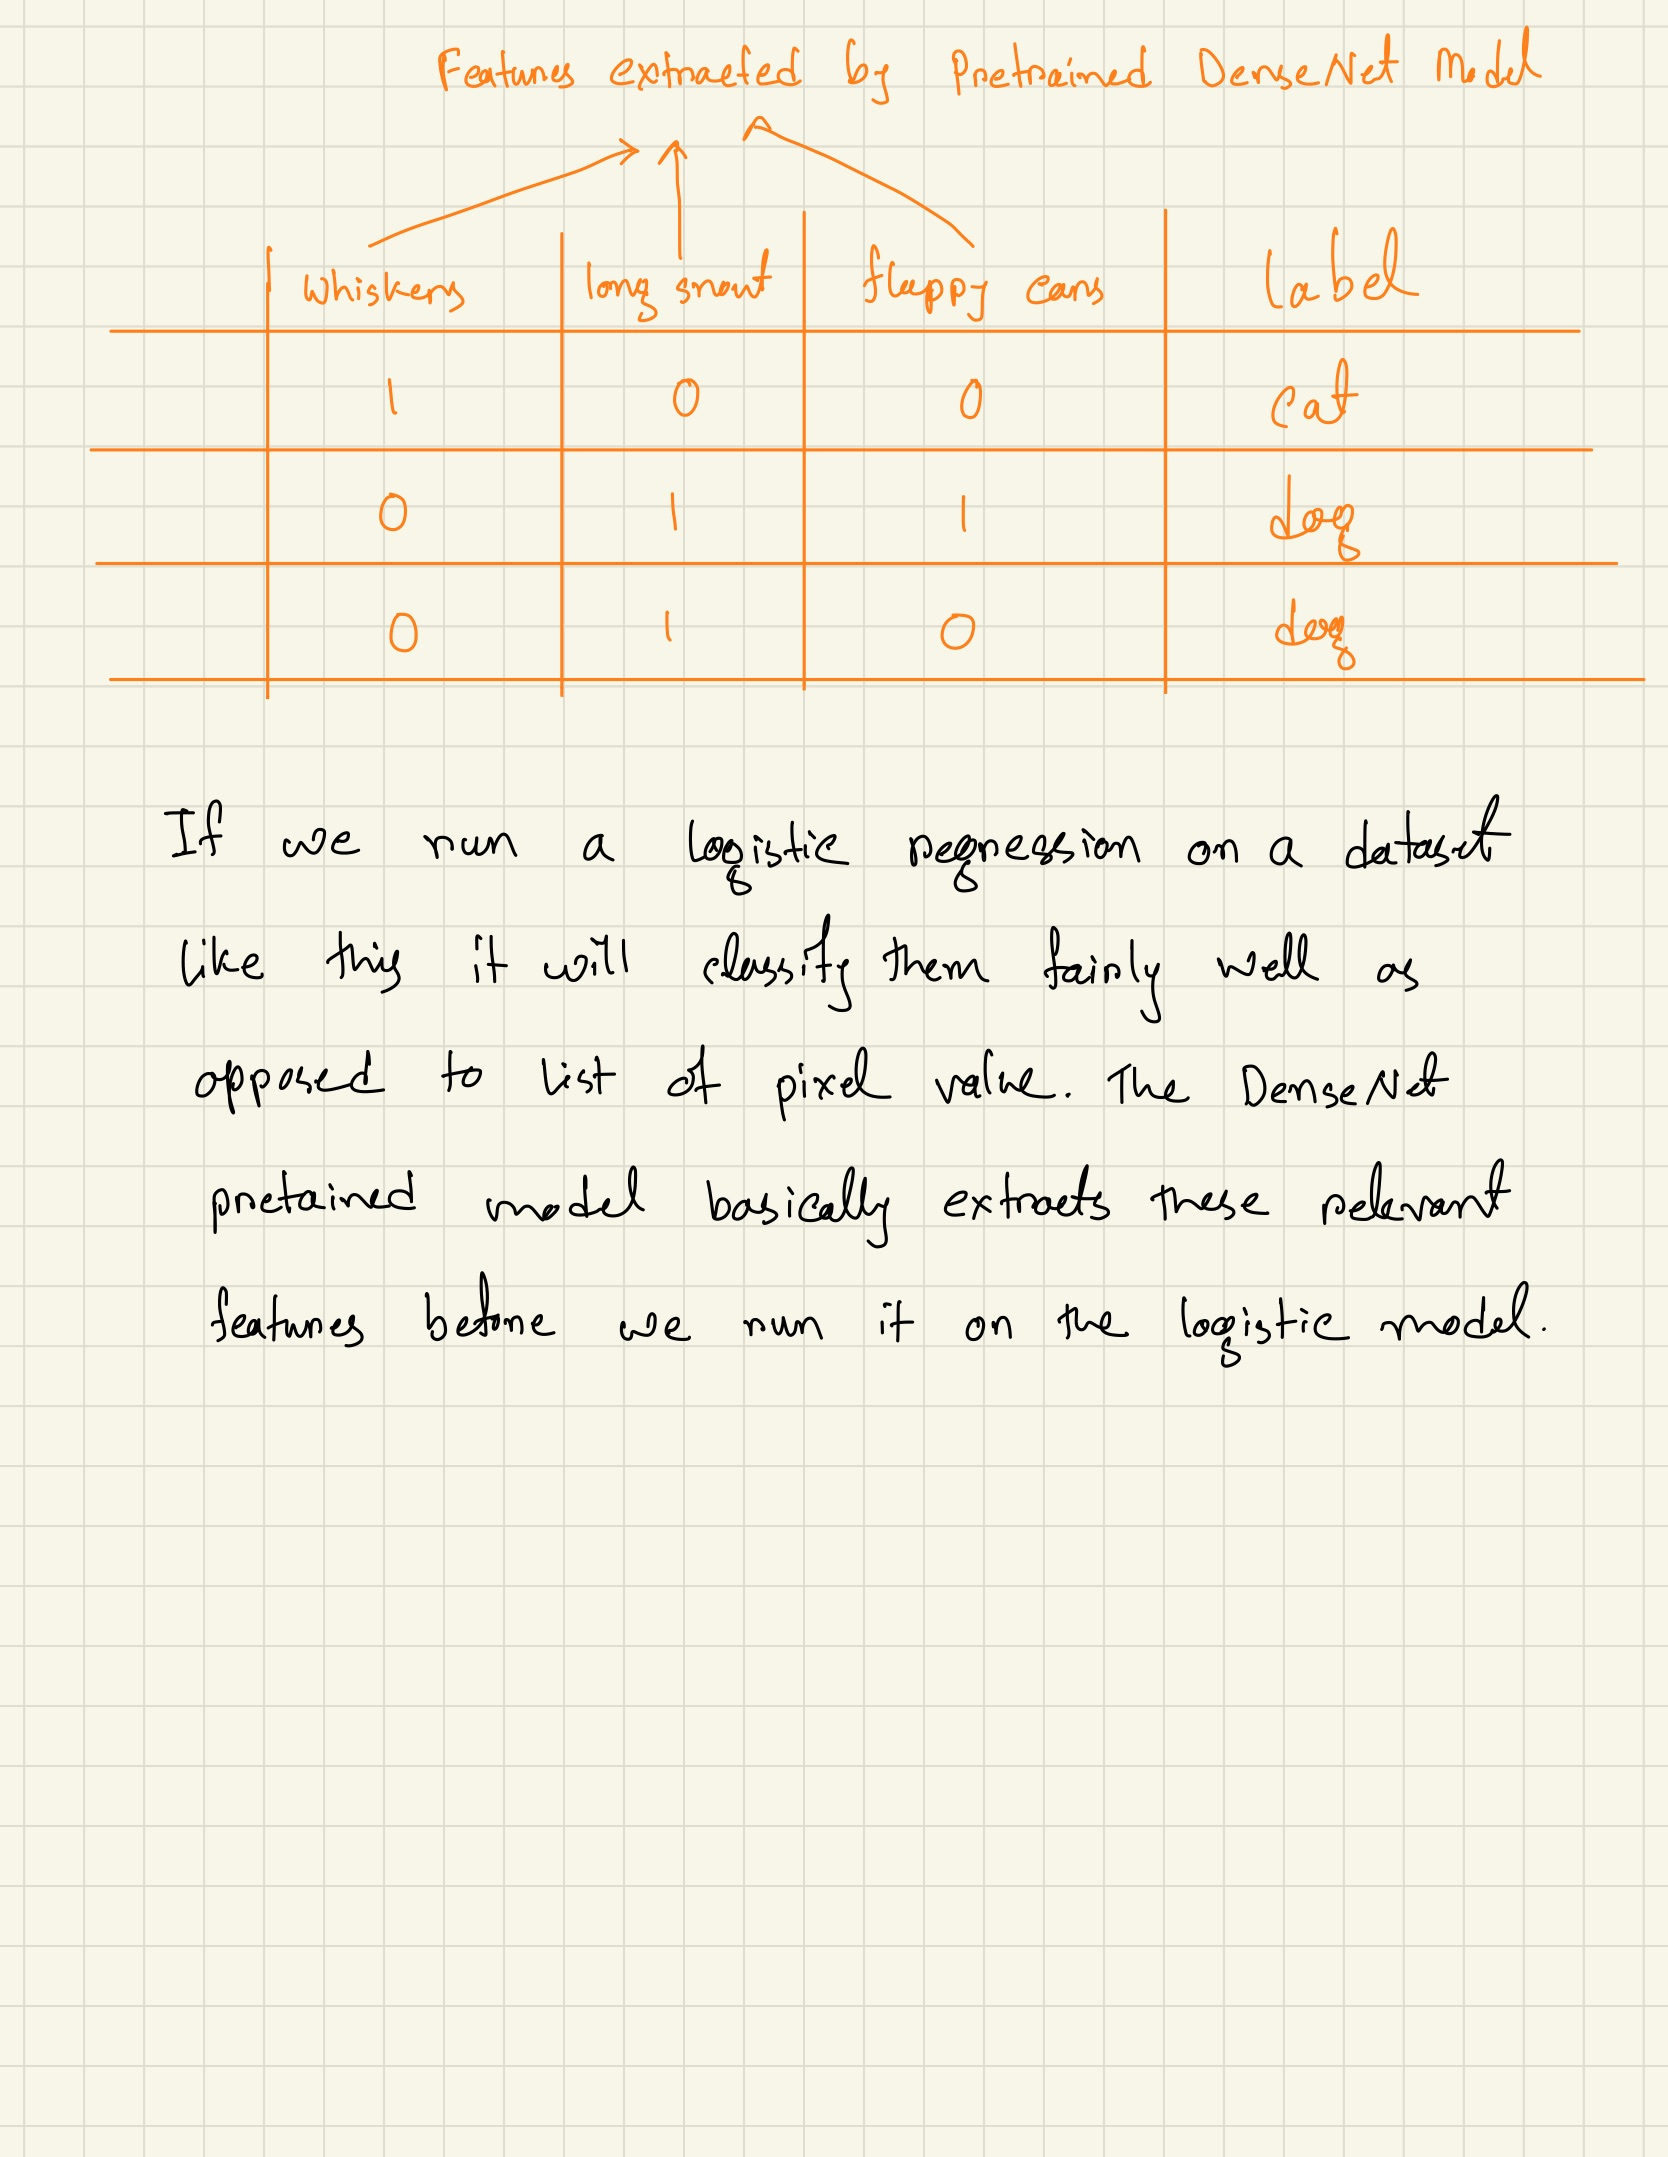

#### Changing the prediction task (switching out the last layer)

Another way to achieve roughly the same thing is to remove the last layer and insert a new one with a different number of outputs. In this case we just need a single output neuron, as we only have 2 classes. 

> **Ex. 6.2.3**: Solve the same classification problem as above, but by following Jason's example under 'Pre-Trained Model as Feature Extractor in Model'. 
> - Use a max-pooling layer when you load the pre-trained model, and
> - only add a single output layer.
> 
> Compare to the accuracy you got in 6.2.2.
>
> *Hint: You might not want to train the entire neural network. You can freeze the weights of layer `i` using `model.layers[i].trainable = False` which can reduce the number of computations needed.

In [54]:
from keras.layers import Flatten, Dense, GlobalMaxPooling2D
from keras.callbacks import EarlyStopping

new_input = Input(shape=(200, 200, 3))
feature_extractor_model2 = DenseNet121(include_top = False, input_tensor = new_input) #again dont include last layer and change input shape

# Add Maxpool layer
max_pool_layer = GlobalMaxPooling2D()(feature_extractor_model2.output)
flat_layer = Flatten()(max_pool_layer)
output_layer = Dense(1, activation='sigmoid')(flat_layer)

feature_extractor_model2 = Model(inputs=feature_extractor_model2.inputs, outputs=output_layer)

for layer in feature_extractor_model2.layers[:-1]:  # Freeze all but the last layer from being able to update the weights
    layer.trainable = False

# testing to make sure trainable params are correct
#feature_extractor_model2.summary()



In [55]:
# Early stopping to prevent overfitting, higher patience because model seems 'jumpier'
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)


feature_extractor_model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = feature_extractor_model2.fit(
    x_train, y_train, 
    validation_data=(x_test, y_test), 
    epochs=40, batch_size=10, 
    callbacks=[early_stopping]
)

Epoch 1/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 476ms/step - accuracy: 0.6029 - loss: 1.2323 - val_accuracy: 0.8660 - val_loss: 0.3446
Epoch 2/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 440ms/step - accuracy: 0.8732 - loss: 0.3643 - val_accuracy: 0.9320 - val_loss: 0.1883
Epoch 3/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 447ms/step - accuracy: 0.9363 - loss: 0.2056 - val_accuracy: 0.9420 - val_loss: 0.1511
Epoch 4/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 458ms/step - accuracy: 0.9205 - loss: 0.1537 - val_accuracy: 0.9400 - val_loss: 0.1418
Epoch 5/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 445ms/step - accuracy: 0.9539 - loss: 0.1318 - val_accuracy: 0.9480 - val_loss: 0.1298
Epoch 6/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 442ms/step - accuracy: 0.9679 - loss: 0.0775 - val_accuracy: 0.9240 - val_loss: 0.1761
Epoch 7/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 448ms/step - accuracy: 0.9680 - loss: 0.0650 - val_accuracy: 0.9460 - val_loss: 0.1406
Epoch 8/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 451ms/step - accuracy: 0.9679 - loss: 0.0753 - val_accu

In [57]:
test_loss, test_accuracy = feature_extractor_model2.evaluate(x_test, y_test, verbose=0) # verbose 0 so no print out

# Print the results
print("Model Accuracy: %.4f" % test_accuracy)


Model Accuracy: 0.9500


We see that we get the same accuracy of 95% since this method and the method above are nearly the same thing with an unchanging feature extractor run into a last layer that learns or performs a logistic regression. Either way, the bulk of the model is the unchanged DenseNet121 that is learning the same features and the last layer is just one fully connected layer and performs nearly the same operation whether it is a logistic regression or a sigmoid activation. In both cases, the model is simply creating a linear boundary for cat/dog and so we expect a very similar performance. Thus we see that no matter how we train the model, we get around a 95% accuracy. 